In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
plt.style.use('ggplot')

In [2]:
df =  pd.read_excel(r"C:\Users\tejwa\Downloads\Take Home Dataset.xlsx")
df.head()

,record_type,recorddate_key,employee_ID,activity_type,hiredate_key,terminationdate_key,month_status,employee_status,termination_reason,length_of_service,...,manager_role,gender_key,ethnicity,marital_status,top_talent,manager_gender_key,manager_age,distance_from_work,#promotions,business_resource_group_member
0,Activity,2023-01-01,3575023,Termination,2022-08-01,2023-01-01,1,Terminated,Involuntary,0,...,0,M,Black,Unknown,1,F,53,17,0,0
1,Activity,2023-01-01,5274023,Termination,2019-06-17,2023-01-01,1,Terminated,Involuntary,3,...,0,M,Black,Single,0,M,47,4,2,0
2,Activity,2023-01-01,8300023,Hire,2023-01-01,NaN,1,Active,NaN,0,...,0,F,Black,Single,1,F,37,9,0,0
3,Activity,2023-01-02,5268023,Termination,2020-10-12,2023-01-02,1,Terminated,Involuntary,2,...,0,M,Black,Single,1,M,41,6,1,1
4,Activity,2023-01-03,5555023,Termination,2022-02-14,2023-01-03,1,Terminated,Involuntary,0,...,0,M,Black,Single,0,M,48,6,0,1


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96866 entries, 0 to 96865
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   record_type                     96866 non-null  object        
 1   recorddate_key                  96866 non-null  datetime64[ns]
 2   employee_ID                     96866 non-null  int64         
 3   activity_type                   3939 non-null   object        
 4   hiredate_key                    96866 non-null  datetime64[ns]
 5   terminationdate_key             1962 non-null   object        
 6   month_status                    96866 non-null  int64         
 7   employee_status                 96866 non-null  object        
 8   termination_reason              1962 non-null   object        
 9   length_of_service               96866 non-null  int64         
 10  employee_type                   96866 non-null  object        
 11  co

In [46]:
# Date conversions
df['recorddate_key'] = pd.to_datetime(df['recorddate_key'])
df['hiredate_key'] = pd.to_datetime(df['hiredate_key'])
df['terminationdate_key'] = pd.to_datetime(df['terminationdate_key'])

# Categorical conversions (for memory efficiency and better performance)
categorical_columns = [
    'record_type',           # 2 values: Activity, Snapshot
    'activity_type',         # 3 values: Termination, Hire, nan
    'employee_status',       # 2 values: Terminated, Active
    'termination_reason',    # 3 values: Involuntary, Voluntary, nan
    'employee_type',         # Likely limited values
    'company',               # Likely limited values
    'department_name',       # Likely limited values
    'country_name',          # Likely limited values
    'city_name',             # Likely limited values
    'gender_key',            # 2 values: M, F
    'ethnicity',             # 4 values: Black, Asian, Other, White
    'marital_status',        # 3 values: Unknown, Single, Married
    'manager_gender_key'     # 2 values: M, F
]

for col in categorical_columns:
    df[col] = df[col].astype('category')

# Boolean conversions (0/1 → True/False)
boolean_columns = ['manager_role', 'top_talent', 'business_resource_group_member']
for col in boolean_columns:
    df[col] = df[col].astype('bool')

In [47]:
import pandas as pd
import numpy as np
from datetime import datetime

def validate_data_consistency(df):
    
    #Perform comprehensive data consistency checks on the employee dataset
    # Store all issues found
    issues = {}
    
    # HIRE DATE CONSISTENCY
    hire_date_issues = df[df['hiredate_key'] > df['recorddate_key']]
    if len(hire_date_issues) > 0:
        issues['hire_date_after_record'] = hire_date_issues.index.tolist()
        print(f"Found {len(hire_date_issues)} rows where hire date > record date")
    else:
        print("All hire dates are valid")
    
    # TERMINATION DATE CONSISTENCY
    term_date_issues = df[
        (df['terminationdate_key'].notna()) & 
        (df['terminationdate_key'] < df['hiredate_key'])
    ]
    if len(term_date_issues) > 0:
        issues['termination_before_hire'] = term_date_issues.index.tolist()
        print(f"Found {len(term_date_issues)} rows where termination date < hire date")
    else:
        print("All termination dates are valid")
    
    # ACTIVITY DATE MATCHING
    # Hire activity should match hire date
    hire_mismatch = df[
        (df['activity_type'] == 'Hire') & 
        (df['hiredate_key'] != df['recorddate_key'])
    ]
    if len(hire_mismatch) > 0:
        issues['hire_activity_date_mismatch'] = hire_mismatch.index.tolist()
        print(f"Found {len(hire_mismatch)} hire activities with mismatched dates")
    else:
        print("All hire activity dates match")
    
    # Termination activity should match termination date
    term_mismatch = df[
        (df['activity_type'] == 'Termination') & 
        (df['terminationdate_key'] != df['recorddate_key'])
    ]
    if len(term_mismatch) > 0:
        issues['termination_activity_date_mismatch'] = term_mismatch.index.tolist()
        print(f"Found {len(term_mismatch)} termination activities with mismatched dates")
    else:
        print("All termination activity dates match")
    
    # SNAPSHOT DATE FORMAT (last day of month)
    snapshot_records = df[df['record_type'] == 'Snapshot'].copy()
    if len(snapshot_records) > 0:
        # Check if recorddate_key is last day of month
        snapshot_records['is_last_day'] = (
            snapshot_records['recorddate_key'] == 
            snapshot_records['recorddate_key'] + pd.offsets.MonthEnd(0)
        )
        invalid_snapshots = snapshot_records[~snapshot_records['is_last_day']]
        if len(invalid_snapshots) > 0:
            issues['invalid_snapshot_dates'] = invalid_snapshots.index.tolist()
            print(f"Found {len(invalid_snapshots)} snapshots not on month-end")
        else:
            print("All snapshot dates are on month-end")
    else:
        print("No snapshot records found")
    
    # MONTH STATUS MATCH
    month_mismatch = df[df['month_status'] != df['recorddate_key'].dt.month]
    if len(month_mismatch) > 0:
        issues['month_status_mismatch'] = month_mismatch.index.tolist()
        print(f"Found {len(month_mismatch)} rows with incorrect month_status")
    else:
        print("All month_status values match record dates")
    
    # TERMINATION STATUS LOGIC
    # Terminated should have termination date
    terminated_no_date = df[
        (df['employee_status'] == 'Terminated') & 
        (df['terminationdate_key'].isna())
    ]
    if len(terminated_no_date) > 0:
        issues['terminated_no_date'] = terminated_no_date.index.tolist()
        print(f"Found {len(terminated_no_date)} terminated employees without termination date")
    else:
        print("All terminated employees have termination dates")
    
    # Active should not have termination date
    active_with_date = df[
        (df['employee_status'] == 'Active') & 
        (df['terminationdate_key'].notna())
    ]
    if len(active_with_date) > 0:
        issues['active_with_termination_date'] = active_with_date.index.tolist()
        print(f"Found {len(active_with_date)} active employees with termination date")
    else:
        print("No active employees have termination dates")
    
    # TERMINATION REASON LOGIC
    # Terminated should have reason
    terminated_no_reason = df[
        (df['employee_status'] == 'Terminated') & 
        (df['termination_reason'].isna())
    ]
    if len(terminated_no_reason) > 0:
        issues['terminated_no_reason'] = terminated_no_reason.index.tolist()
        print(f"Found {len(terminated_no_reason)} terminated employees without reason")
    else:
        print("All terminated employees have termination reasons")
    
    # Active should not have reason
    active_with_reason = df[
        (df['employee_status'] == 'Active') & 
        (df['termination_reason'].notna())
    ]
    if len(active_with_reason) > 0:
        issues['active_with_termination_reason'] = active_with_reason.index.tolist()
        print(f"Found {len(active_with_reason)} active employees with termination reason")
    else:
        print("No active employees have termination reasons")
    
    # RECORD TYPE VS ACTIVITY TYPE
    # Activity records should have activity type
    activity_no_type = df[
        (df['record_type'] == 'Activity') & 
        (df['activity_type'].isna())
    ]
    if len(activity_no_type) > 0:
        issues['activity_no_type'] = activity_no_type.index.tolist()
        print(f"Found {len(activity_no_type)} activity records without activity type")
    else:
        print("All activity records have activity types")
    
    # Snapshot records should not have activity type
    snapshot_with_type = df[
        (df['record_type'] == 'Snapshot') & 
        (df['activity_type'].notna())
    ]
    if len(snapshot_with_type) > 0:
        issues['snapshot_with_activity'] = snapshot_with_type.index.tolist()
        print(f"Found {len(snapshot_with_type)} snapshot records with activity type")
    else:
        print("No snapshot records have activity types")
    
    # ACTIVITY STATUS MATCH
    # Termination activities should have terminated status
    term_activity_wrong_status = df[
        (df['activity_type'] == 'Termination') & 
        (df['employee_status'] != 'Terminated')
    ]
    if len(term_activity_wrong_status) > 0:
        issues['termination_activity_wrong_status'] = term_activity_wrong_status.index.tolist()
        print(f"Found {len(term_activity_wrong_status)} termination activities with wrong status")
    else:
        print("All termination activities have terminated status")
    
    # LENGTH OF SERVICE CALCULATION
    df_temp = df.copy()
    df_temp['calculated_length'] = (
        (df_temp['recorddate_key'] - df_temp['hiredate_key']).dt.days / 365.25
    ).round().astype(int)
    
    length_mismatch = df_temp[
        abs(df_temp['length_of_service'] - df_temp['calculated_length']) > 1
    ]
    if len(length_mismatch) > 0:
        issues['length_of_service_mismatch'] = length_mismatch.index.tolist()
        print(f"Found {len(length_mismatch)} rows with incorrect length of service")
    else:
        print("All length of service calculations are correct")
    
    # AGE RANGES
    invalid_ages = df[(df['age'] < 16) | (df['age'] > 85)]
    if len(invalid_ages) > 0:
        issues['invalid_employee_ages'] = invalid_ages.index.tolist()
        print(f"Found {len(invalid_ages)} employees with invalid ages")
    else:
        print("All employee ages are within valid range")
    
    invalid_manager_ages = df[(df['manager_age'] < 18) | (df['manager_age'] > 85)]
    if len(invalid_manager_ages) > 0:
        issues['invalid_manager_ages'] = invalid_manager_ages.index.tolist()
        print(f" Found {len(invalid_manager_ages)} managers with invalid ages")
    else:
        print("All manager ages are within valid range")
    
    # NUMERIC BOUNDS
    negative_promotions = df[df['#promotions'] < 0]
    if len(negative_promotions) > 0:
        issues['negative_promotions'] = negative_promotions.index.tolist()
        print(f"Found {len(negative_promotions)} rows with negative promotions")
    else:
        print("All promotion counts are non-negative")
    
    negative_distance = df[df['distance_from_work'] < 0]
    if len(negative_distance) > 0:
        issues['negative_distance'] = negative_distance.index.tolist()
        print(f"Found {len(negative_distance)} rows with negative distance")
    else:
        print("All distances are non-negative")
    
    negative_service = df[df['length_of_service'] < 0]
    if len(negative_service) > 0:
        issues['negative_service'] = negative_service.index.tolist()
        print(f"Found {len(negative_service)} rows with negative length of service")
    else:
        print(" All length of service values are non-negative")
    
    
    # REQUIRED FIELD CHECKS
    required_fields = ['employee_ID', 'recorddate_key', 'hiredate_key', 'employee_status', 'record_type']
    for field in required_fields:
        null_count = df[field].isna().sum()
        if null_count > 0:
            issues[f'null_{field}'] = df[df[field].isna()].index.tolist()
            print(f"Found {null_count} null values in required field: {field}")
        else:
            print(f"No null values in {field}")
    
    # EMPLOYEE ID UNIQUENESS PER DATE
    duplicates = df.duplicated(subset=['employee_ID', 'recorddate_key'], keep=False)
    if duplicates.sum() > 0:
        issues['duplicate_employee_date'] = df[duplicates].index.tolist()
        print(f"Found {duplicates.sum()} duplicate employee-date combinations")
    else:
        print("All employee-date combinations are unique")
    
    # Summary
    print("\n" + "=" * 50)
    print("VALIDATION SUMMARY")
    print("=" * 50)
    
    if len(issues) == 0:
        print("ALL CHECKS PASSED! No data consistency issues found.")
    else:
        print(f"Found {len(issues)} types of data consistency issues:")
        for issue_type, row_indices in issues.items():
            print(f"   - {issue_type}: {len(row_indices)} rows")
    
    return issues

# Run the validation
issues_found = validate_data_consistency(df)

# Optional: Show details of specific issues
def show_issue_details(df, issues_dict, issue_type, max_rows=5):
    """Show details of specific data issues"""
    if issue_type in issues_dict:
        problem_rows = issues_dict[issue_type][:max_rows]
        print(f"\nDetails for {issue_type} (showing first {min(len(problem_rows), max_rows)} rows):")
        relevant_columns = ['employee_ID', 'recorddate_key', 'hiredate_key', 'terminationdate_key', 
                          'record_type', 'activity_type', 'employee_status', 'termination_reason']
        return df.loc[problem_rows, relevant_columns]
    else:
        print(f"No issues found for: {issue_type}")

indices_to_drop = set()
for issue_type, index_list in issues_found.items():
    indices_to_drop.update(index_list)

# Convert the set to a list for the .drop() method
list_of_indices_to_drop = list(indices_to_drop)

print(f"Original number of rows in df: {len(df)}")
print(f"Found {len(list_of_indices_to_drop)} unique rows with data consistency issues to remove.")

# Create a new DataFrame without the problematic rows
df_cleaned = df.drop(index=list_of_indices_to_drop)

print(f"Number of rows in the new cleaned df: {len(df_cleaned)}")
print(f"Total rows removed: {len(df) - len(df_cleaned)}")

df_cleaned.head()

df = df_cleaned

Found 321 rows where hire date > record date
Found 90 rows where termination date < hire date
Found 35 hire activities with mismatched dates
All termination activity dates match
All snapshot dates are on month-end
All month_status values match record dates
All terminated employees have termination dates
No active employees have termination dates
All terminated employees have termination reasons
No active employees have termination reasons
All activity records have activity types
No snapshot records have activity types
All termination activities have terminated status
All length of service calculations are correct
All employee ages are within valid range
All manager ages are within valid range
All promotion counts are non-negative
All distances are non-negative
 All length of service values are non-negative
No null values in employee_ID
No null values in recorddate_key
No null values in hiredate_key
No null values in employee_status
No null values in record_type
Found 424 duplicate empl

In [51]:

# 1) Sort and keep latest record per employee, then make an explicit copy
df = (
    df.sort_values(by=['recorddate_key', 'employee_ID'], ascending=[False, True])
      .drop_duplicates(subset='employee_ID', keep='first')
      .copy()
)

# 2) Lower-case termination_reason using .loc to avoid view warnings
df.loc[:, 'termination_reason'] = df['termination_reason'].str.lower()

# 3) Filter out involuntary exits, then copy again
mask = df['termination_reason'].isna() | (df['termination_reason'].str.strip() != 'involuntary')
df = df.loc[mask].copy()

# 4) Create voluntary_termination flag safely via .loc
df.loc[:, 'voluntary_termination'] = (
    df['termination_reason']
      .apply(lambda x: 1 if isinstance(x, str) and x.strip() == 'voluntary' else 0)
)

# Now df.head() and df.shape will work without SettingWithCopyWarning
df.head(), df.shape


(      record_type recorddate_key  employee_ID activity_type hiredate_key  \
 93001    Snapshot     2023-12-31      1013002           NaN   1983-09-19   
 93002    Snapshot     2023-12-31      1013302           NaN   2019-06-17   
 93003    Snapshot     2023-12-31      1013502           NaN   1987-04-13   
 93004    Snapshot     2023-12-31      1013602           NaN   1991-12-07   
 93005    Snapshot     2023-12-31      1013902           NaN   2019-06-17   
 
       terminationdate_key  month_status employee_status termination_reason  \
 93001                 NaN            12          Active                NaN   
 93002                 NaN            12          Active                NaN   
 93003                 NaN            12          Active                NaN   
 93004                 NaN            12          Active                NaN   
 93005                 NaN            12          Active                NaN   
 
        length_of_service  ... gender_key ethnicity marital_

In [9]:
df.columns
df['termination_reason'].value_counts()

termination_reason
voluntary    809
Name: count, dtype: int64

In [10]:
import pandas as pd
from scipy.stats import ttest_ind

#convert columns to boolean
binary_cols = [
    'manager_role',
    'business_resource_group_member',
    'voluntary_termination',
    'top_talent'
]

# Cast to actual booleans
df[binary_cols] = df[binary_cols].astype('bool')

#Show data types for every column
print("Column datatypes:\n", df.dtypes)

Column datatypes:
 record_type                             category
recorddate_key                    datetime64[ns]
employee_ID                                int64
activity_type                           category
hiredate_key                      datetime64[ns]
terminationdate_key               datetime64[ns]
month_status                               int64
employee_status                         category
termination_reason                        object
length_of_service                          int64
employee_type                           category
company                                 category
department_name                         category
country_name                            category
city_name                               category
age                                        int64
manager_role                                bool
gender_key                              category
ethnicity                               category
marital_status                          category
t

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, chi2_contingency

# independent variable
iv = 'voluntary_termination'
# Exclude these from analysis
exclude = {
    'numeric':   [iv, 'employee_ID','month_status'],               
    'categorical': [iv, 'employee_ID',               #  drop dates drop labels + ID
                    'recorddate_key','hiredate_key','terminationdate_key','record_type','activity_type','employee_status',
                    'termination_reason','employee_type']}

# Identify continuous (numeric) vars
cont_vars = [
    col for col in df.select_dtypes(include=['number']).columns
    if col not in exclude['numeric']]
# Identify categorical vars (object or bool)
cat_vars = [
    col for col in df.select_dtypes(include=['object','bool','category']).columns
    if col not in exclude['categorical']]

# T-Tests on Continuous Variables
t_results = []
# split groups once
grp0 = df[df[iv] == False]
grp1 = df[df[iv] == True]

for col in cont_vars:
    x0 = grp0[col].dropna()
    x1 = grp1[col].dropna()
    t_stat, p_val = ttest_ind(x0, x1, equal_var=False)
    t_results.append({
        'variable':      col,
        'mean_stayed':   x0.mean(),
        'mean_left':     x1.mean(),
        't_statistic':   t_stat,
        'p_value':       p_val})

t_df = pd.DataFrame(t_results).set_index('variable').round(4)

# Chi-Square on Categorical Variables
chi2_results = []
for col in cat_vars:
    # build contingency table
    ct = pd.crosstab(df[col], df[iv])
    chi2, p, dof, _ = chi2_contingency(ct)
    chi2_results.append({
        'variable':      col,
        'chi2_statistic': chi2,
        'p_value':        p,
        'dof':            dof
    })
chi2_df = pd.DataFrame(chi2_results).set_index('variable').round(4)


# Display
print("T-Test Results (continuous vars)")
print(t_df)

print("Chi-Square Results (categorical vars)")
print(chi2_df)


T-Test Results (continuous vars)
                    mean_stayed  mean_left  t_statistic  p_value
variable                                                        
length_of_service        6.8255     4.0593      13.6986   0.0000
age                     44.0868    43.3807       1.5283   0.1268
manager_age             42.0013    41.8863       0.3972   0.6913
distance_from_work      13.3399    14.4598      -3.0299   0.0025
#promotions              2.4688     1.6415      13.3942   0.0000
Chi-Square Results (categorical vars)
                                chi2_statistic  p_value  dof
variable                                                    
company                                73.7545   0.0000    2
department_name                      1521.4435   0.0000   10
country_name                            0.0000   1.0000    0
city_name                             252.3695   0.0000   11
manager_role                          113.7373   0.0000    1
gender_key                              0.0004 

C:\Users\tejwa\AppData\Local\Temp\ipykernel_33596\382412792.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('tenure_band')['voluntary_termination']
C:\Users\tejwa\AppData\Local\Temp\ipykernel_33596\382412792.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('tenure_band')


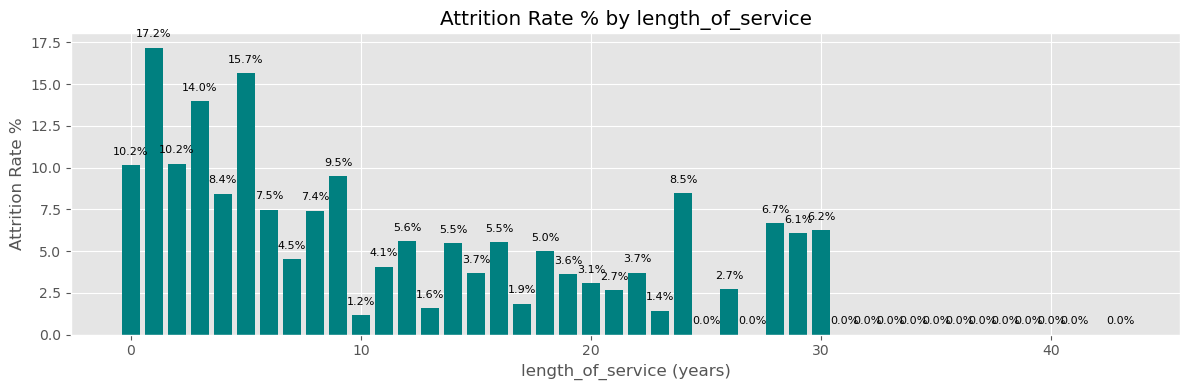

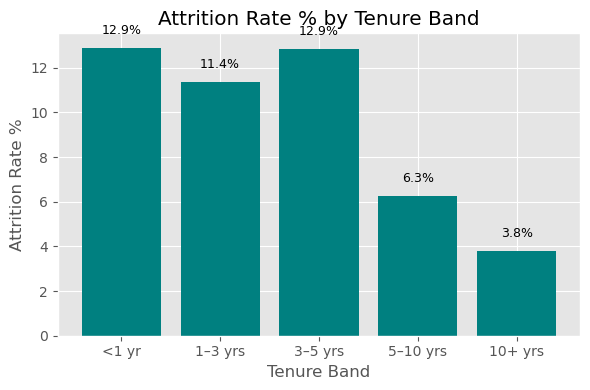

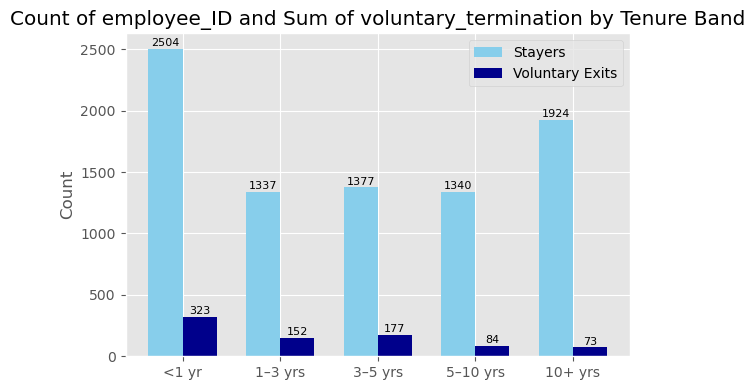

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# CALCULATE ATTRITION RATE BY EXACT TENURE
# Attrition rate (%) at each length_of_service
filtered_df = df[df['length_of_service'] <= 43]

attrition_by_ls = (
    filtered_df
    .groupby('length_of_service')['voluntary_termination']
    .mean()
    .mul(100)
    .sort_index()
)

# DEFINE TENURE BANDS
bins  = [-1, 1, 3, 5, 10, df['length_of_service'].max()]
labels = ['<1 yr', '1–3 yrs', '3–5 yrs', '5–10 yrs', '10+ yrs']
df['tenure_band'] = pd.cut(df['length_of_service'], bins=bins, labels=labels)

# ─── 3. CALCULATE ATTRITION RATE BY TENURE BAND ───────────────────────────────
attrition_by_band = (
    df
    .groupby('tenure_band')['voluntary_termination']
    .mean()
    .mul(100)
    .reindex(labels)   # preserve order
)

# ─── 4. COUNT EMPLOYEES & EXITS BY TENURE BAND ────────────────────────────────
count_and_exits = (
    df
    .groupby('tenure_band')
    .agg(
        employee_count      = ('employee_ID',           'count'),
        voluntary_exits     = ('voluntary_termination', 'sum')
    )
    .reindex(labels)
)

# ─── 5. PLOT 1: Attrition Rate % by exact length_of_service ───────────────────
plt.figure(figsize=(12,4))
plt.bar(attrition_by_ls.index, attrition_by_ls.values, color='teal')
plt.title('Attrition Rate % by length_of_service')
plt.xlabel('length_of_service (years)')
plt.ylabel('Attrition Rate %')
# annotate bars
for x, y in zip(attrition_by_ls.index, attrition_by_ls.values):
    plt.text(x, y + 0.5, f'{y:.1f}%', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()

# ─── 6. PLOT 2: Attrition Rate % by Tenure Band ───────────────────────────────
plt.figure(figsize=(6,4))
plt.bar(attrition_by_band.index.astype(str), attrition_by_band.values, color='teal')
plt.title('Attrition Rate % by Tenure Band')
plt.xlabel('Tenure Band')
plt.ylabel('Attrition Rate %')
for x, y in zip(attrition_by_band.index.astype(str), attrition_by_band.values):
    plt.text(x, y + 0.5, f'{y:.1f}%', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# ─── 7. PLOT 3: Counts vs Voluntary Exits by Tenure Band ───────────────────────
plt.figure(figsize=(6,4))
idx = range(len(labels))
width = 0.35

plt.bar(idx, count_and_exits['employee_count'],   width, label='Stayers', color='skyblue')
plt.bar([i+width for i in idx], count_and_exits['voluntary_exits'], width, label='Voluntary Exits',color='darkblue')

plt.xticks([i+width/2 for i in idx], labels)
plt.title('Count of employee_ID and Sum of voluntary_termination by Tenure Band')
plt.ylabel('Count')
plt.legend()

# annotate
for i, (emp, vol) in enumerate(zip(count_and_exits['employee_count'],
                                   count_and_exits['voluntary_exits'])):
    plt.text(i,       emp + 5, str(emp), ha='center', va='bottom', fontsize=8)
    plt.text(i+width, vol + 5, str(vol), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


     month  attrition_rate_pct
2023-01-01            1.030111
2023-02-01            0.784416
2023-03-01            0.769431
2023-04-01            0.876275
2023-05-01            0.942038
2023-06-01            0.923817
2023-07-01            0.504668
2023-08-01            0.856920
2023-09-01            0.917431
2023-10-01            1.140441
2023-11-01            1.049533
2023-12-01            1.080448


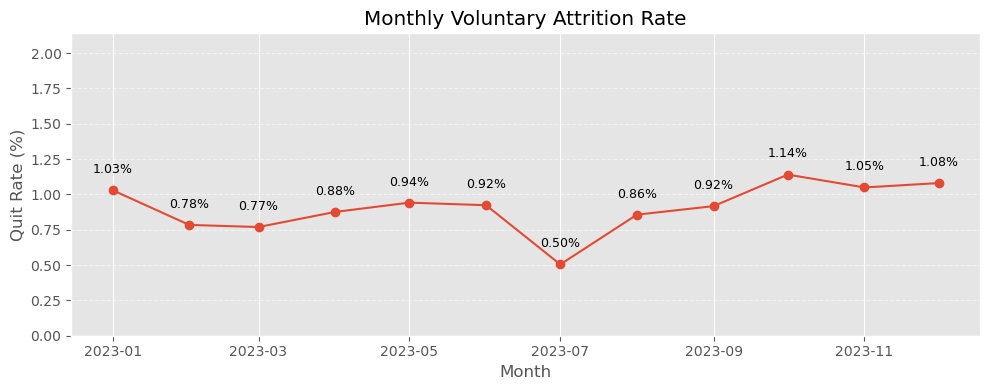

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

raw = pd.read_excel(r"C:\Users\tejwa\Downloads\Take Home Dataset.xlsx")   
raw['recorddate_key']     = pd.to_datetime(raw['recorddate_key'])
raw['terminationdate_key'] = pd.to_datetime(raw['terminationdate_key'])

# 2) Denominator: active headcount from monthly snapshots
snapshots = raw[raw['record_type']=='Snapshot'].copy()
snapshots['month'] = snapshots['recorddate_key'].dt.to_period('M')
headcount = (
    snapshots
    .groupby('month')['employee_ID']
    .nunique()
    .rename('headcount')
)

# 3) Numerator: voluntary terminations
terms = raw[
    (raw['record_type']=='Activity') &
    (raw['activity_type']=='Termination') &
    (raw['termination_reason'].str.lower().str.strip()=='voluntary')
].copy()
terms['month'] = terms['terminationdate_key'].dt.to_period('M')
quits = (
    terms
    .groupby('month')['employee_ID']
    .count()
    .rename('voluntary_quits')
)

# 4) Combine into one DataFrame
monthly = pd.concat([headcount, quits], axis=1).fillna(0)
monthly['attrition_rate_pct'] = 100 * monthly['voluntary_quits'] / monthly['headcount']
monthly = monthly.reset_index()
monthly['month'] = monthly['month'].dt.to_timestamp()

# 5) Print table
print(monthly[['month','attrition_rate_pct']].to_string(index=False))

# 6) Plot the result
plt.figure(figsize=(10,4))
plt.plot(monthly['month'], monthly['attrition_rate_pct'], marker='o')
plt.title('Monthly Voluntary Attrition Rate')
plt.xlabel('Month')
plt.ylabel('Quit Rate (%)')
plt.ylim(0, monthly['attrition_rate_pct'].max() + 1)

for x,y in zip(monthly['month'], monthly['attrition_rate_pct']):
    plt.text(x, y+0.1, f"{y:.2f}%", ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Variance Inflation Factors:
                          variable    VIF
0                    month_status  21.42
1               length_of_service   5.27
2                             age  16.99
3                    manager_role   3.98
4                      top_talent   2.46
5                     manager_age  19.35
6              distance_from_work   2.71
7                     #promotions   7.36
8  business_resource_group_member   1.79


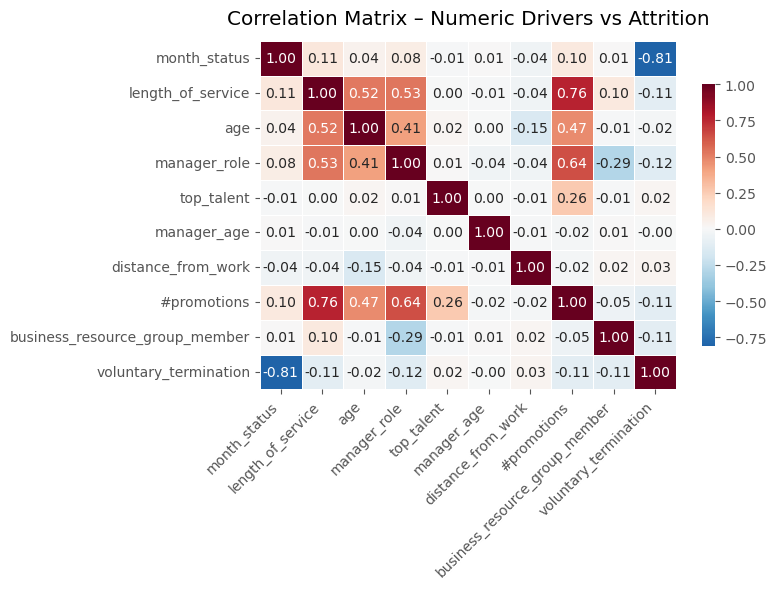

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Select all numeric & boolean columns, then drop employee_ID
numeric_bool_cols = df.select_dtypes(include=['number', 'bool']).columns.tolist()
if 'employee_ID' in numeric_bool_cols:
    numeric_bool_cols.remove('employee_ID')

# 2) Compute VIF for each predictor (exclude the attrition flag here)
vif_cols = [col for col in numeric_bool_cols if col != 'voluntary_termination']
X = df[vif_cols].astype(float).fillna(0)
vif_data = pd.DataFrame({
    'variable': vif_cols,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print("Variance Inflation Factors:\n", vif_data.round(2))

# 3) Compute the full Pearson correlation matrix (with attrition flag included)
corr_df = df[numeric_bool_cols]
corr_matrix = corr_df.corr().round(2)

# 4) Plot a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)
plt.title("Correlation Matrix – Numeric Drivers vs Attrition", pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


# Target & engineered bands
df["Attrition_Flag"] = df["voluntary_termination"].astype(int)

df["tenure_band"] = pd.cut(
    df["length_of_service"],
    bins=[-np.inf, 1, 3, 5, 10, np.inf],
    labels=["<1","1-3","3-5","5-10","10+"]
)

df["age_band"] = pd.cut(
    df["age"],
    bins=[-np.inf, 24, 34, 44, 54, 64, np.inf],
    labels=["18-24","25-34","35-44","45-54","55-64","65+"]
)

df["distance_band"] = pd.cut(
    df["distance_from_work"],
    bins=[-np.inf, 10, 20, np.inf],
    labels=["≤10","10-20","20+"]
)

df["promotion_band"] = pd.cut(
    df["#promotions"],
    bins=[-np.inf, 0, 2, np.inf],
    labels=["0","1-2","3+"]
)

# 3. Define feature columns
cat_cols = [
    "tenure_band", "age_band", "distance_band", "promotion_band",
    "manager_role", "top_talent", "business_resource_group_member",
    "gender_key", "ethnicity", "marital_status"
]

cat_cols = [c for c in cat_cols if c in df.columns]

# Train / test split
X = df[cat_cols]
y = df["Attrition_Flag"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Logistic Regression pipeline with proper scaling
preprocess = ColumnTransformer(transformers=[
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
], remainder="drop")

log_clf = Pipeline([
    ("prep", preprocess),
    ("logit", LogisticRegression(
        solver="liblinear", class_weight="balanced", max_iter=300, random_state=42
    ))
])
# <-- balanced tells sklearn to up-weight the minority class
# Fit model
log_clf.fit(X_train, y_train)

# Predict & evaluate
from sklearn.metrics import classification_report, roc_auc_score

y_pred = log_clf.predict(X_test)
y_prob = log_clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 3))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.63      0.78     19206
           1       0.02      0.69      0.03       168

    accuracy                           0.64     19374
   macro avg       0.51      0.66      0.40     19374
weighted avg       0.99      0.64      0.77     19374

ROC AUC: 0.719


Top 5 attrition *drivers* (highest odds‐ratios):
                   feature  odds_ratio
0  cat__promotion_band_1-2        2.82
1        cat__age_band_65+        2.25
2      cat__age_band_55-64        1.94
3      cat__age_band_45-54        1.78
4        cat__top_talent_1        1.64 

Top 5 *protective* factors (lowest odds‐ratios):
                                  feature  odds_ratio
17                   cat__ethnicity_White        0.85
18                   cat__tenure_band_10+        0.83
19                 cat__promotion_band_3+        0.71
20                    cat__manager_role_1        0.38
21  cat__business_resource_group_member_1        0.28


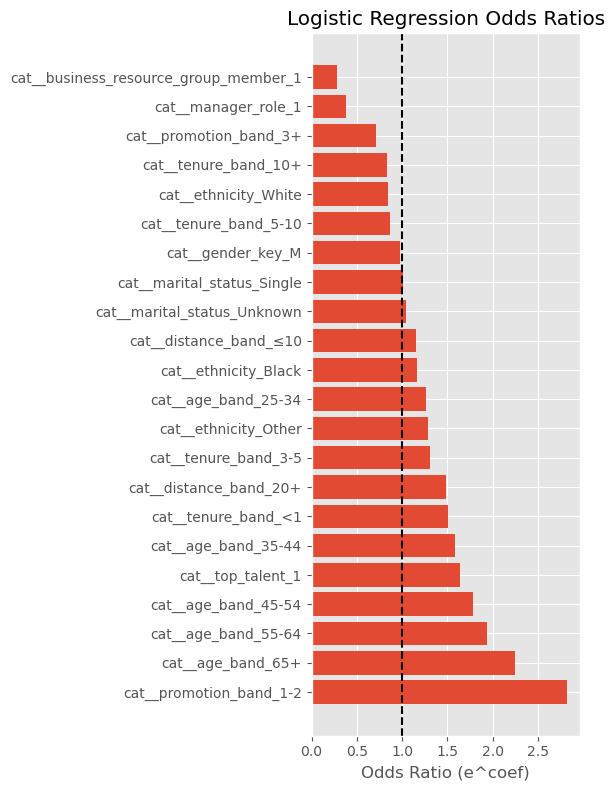

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Extract feature names & coefs 
preprocessor = log_clf.named_steps['prep']
feature_names = preprocessor.get_feature_names_out()
coefs        = log_clf.named_steps['logit'].coef_[0]

# Build DataFrame
coef_df = pd.DataFrame({
    'feature':      feature_names,
    'coef':         coefs
})
coef_df['odds_ratio'] = np.exp(coef_df['coef'])
coef_df = coef_df.sort_values(by='odds_ratio', ascending=False).reset_index(drop=True)

#Show top drivers & top protectors
top_positive = coef_df.head(5)
top_negative = coef_df.tail(5)

print("Top 5 attrition *drivers* (highest odds‐ratios):")
print(top_positive[['feature','odds_ratio']].round(2), "\n")

print("Top 5 *protective* factors (lowest odds‐ratios):")
print(top_negative[['feature','odds_ratio']].round(2))

#Visualize all odds‐ratios 
plt.figure(figsize=(6,8))
plt.barh(coef_df['feature'], coef_df['odds_ratio'])
plt.axvline(1, color='k', linestyle='--')
plt.xlabel('Odds Ratio (e^coef)')
plt.title('Logistic Regression Odds Ratios')
plt.tight_layout()
plt.show()


In [73]:
import statsmodels.api as sm
import pandas as pd

# 1) One-hot encode the categoricals
X_cat = pd.get_dummies(
    X_train[cat_cols],
    drop_first=True
)

X_design = X_cat.copy()

# 3) Add intercept column
X_design = sm.add_constant(X_design)

# 4) Cast everything to float
X_design = X_design.astype(float)

# 5) Fit the logit
sm_logit = sm.Logit(y_train, X_design).fit(disp=False)

# 6) Print coefficient table with p-values & 95% CIs
print(sm_logit.summary2().tables[1])


                                   Coef.  Std.Err.          z         P>|z|  \
const                          -4.963267  0.239977 -20.682224  5.007796e-95   
manager_role                   -0.940068  0.104675  -8.980838  2.687132e-19   
top_talent                      0.365881  0.088784   4.121033  3.771779e-05   
business_resource_group_member -1.183504  0.106603 -11.101991  1.226802e-28   
tenure_band_1-3                -0.163813  0.140804  -1.163418  2.446599e-01   
tenure_band_3-5                 0.035176  0.163016   0.215781  8.291586e-01   
tenure_band_5-10               -0.330701  0.189346  -1.746542  8.071676e-02   
tenure_band_10+                -0.409071  0.205748  -1.988220  4.678739e-02   
age_band_25-34                  0.212466  0.202099   1.051297  2.931223e-01   
age_band_35-44                  0.443853  0.207303   2.141085  3.226721e-02   
age_band_45-54                  0.663024  0.214056   3.097426  1.952090e-03   
age_band_55-64                  0.858543  0.220791  


Random Forest
ROC-AUC : 0.762 | Acc: 0.934 | P: 0.017 | R: 0.113 | F1: 0.029


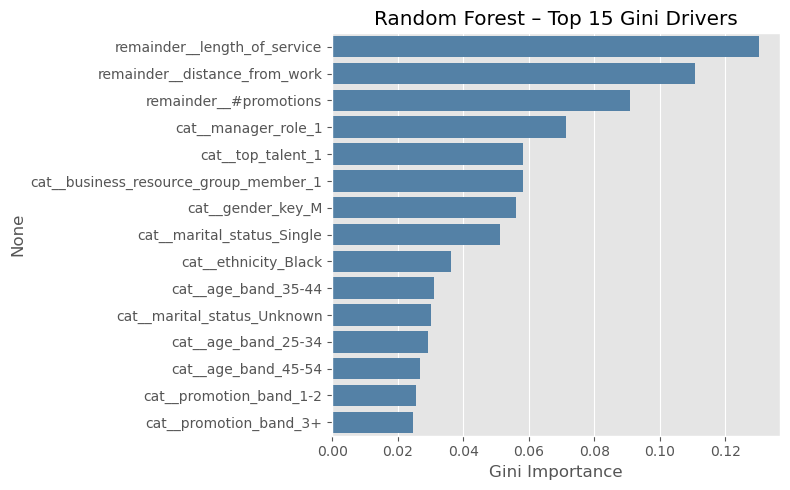

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


cat_cols = [
    "tenure_band", "age_band", "distance_band", "promotion_band",
    "manager_role", "top_talent", "business_resource_group_member",
    "gender_key", "ethnicity", "marital_status"
]
num_cols = ["length_of_service", "#promotions", "distance_from_work"]

X = df[cat_cols + num_cols]
y = df["Attrition_Flag"]

# Train/Test Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# Preprocessor
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols)
    ],
    remainder="passthrough"   # numeric columns will pass through unchanged
)

# Random Forest Pipeline
rf_clf = Pipeline([
    ("prep", preprocess),
    ("rf", RandomForestClassifier(
        n_estimators=400,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ))
])

# Fit & Predict 
rf_clf.fit(X_train, y_train)

y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_rf = rf_clf.predict(X_test)

# Metrics Helper
def show_metrics(name, y_true, y_prob, y_pred):
    print(f"\n{name}")
    print(
        "ROC-AUC :", round(roc_auc_score(y_true, y_prob),3),
        "| Acc:",  round(accuracy_score(y_true, y_pred),3),
        "| P:",    round(precision_score(y_true, y_pred),3),
        "| R:",    round(recall_score(y_true, y_pred),3),
        "| F1:",   round(f1_score(y_true, y_pred),3)
    )

show_metrics("Random Forest", y_test, y_prob_rf, y_pred_rf)

#  Gini Feature Importances
# 7.1 Extract the fitted preprocessor and its output feature names
pre = rf_clf.named_steps["prep"]
feature_names = pre.get_feature_names_out()  # includes all OHE cols + passthrough numerics

# Pull out the forest’s importances
importances = rf_clf.named_steps["rf"].feature_importances_

# 7.3 Build a Series, sort & display top 15
imp = (
    pd.Series(importances, index=feature_names)
      .sort_values(ascending=False)
      .head(15)
)

# 7.4 Plot
plt.figure(figsize=(8,5))
sns.barplot(x=imp.values, y=imp.index, color="steelblue")
plt.title("Random Forest – Top 15 Gini Drivers")
plt.xlabel("Gini Importance")
plt.tight_layout()
plt.show()
